In [1]:
import settings
from models import *
from epmt_job import setup_orm_db
import fnmatch

setup_orm_db()


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams['figure.figsize'] = [15, 8]

def barplot(labels=[], y_val=[], mn="None", yscale="log", title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    plt.bar(index, y_val)
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn)
    plt.title(mn+' '+title_suffix)
    plt.show()

def barplot_stack(labels=[], y_val=[], y2_val=[], mn=[], yscale="log", ylim=(), title_suffix="by executable"):
    index = np.arange(len(labels))
    plt.yscale(yscale)
    p1 = plt.bar(index, y_val, color='r')
    p2 = plt.bar(index, y2_val, bottom=y_val, color='g')
# performance, align='center', alpha=0.5)
    plt.xticks(index, labels, fontsize=10, rotation=45)
# y_pos, objects)
    plt.ylabel(mn[0]+"+"+mn[1])
    plt.legend((p1[0], p2[0]), (mn[0], mn[1]))
    plt.title(mn[0]+"+"+mn[1]+' '+title_suffix)
    plt.ylim(ylim)
    plt.show()



In [3]:
def get_job_list():
    q = select(j for j in Job)
    return q[:]
    
# Return list of objects for jobid

def get_processes_job(jobid):
    # lookup job
    try:
        j = Job[jobid]
    except Exception as e:
        print "not found",e
        return None
    print "Found job",jobid,"with",len(j.processes),"processes and",len(j.processes.threads),"threads"
    return j.processes
    
# Reduce all processes by executable name and return sums of metric

    # we could do this with a query, maybe
    # processes=select((p.exename, sum(p.duration), count(p)) for p in Process if p.job == j).order_by(-2)
    #    for p in processes:
    #        threads += p.threads

def get_job_processes_reduce_attr(jobid, attr_name, cutoff=0.0, exelen=10):
    processes = get_processes_job(jobid)
    if not processes:
        return
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen]
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename]["count"] = 1
            proc_dict[exename]["threads"] = len(p.threads)
            proc_dict[exename][attr_name] = getattr(p, attr_name)
        else:
            proc_dict[exename]["count"] += 1
            proc_dict[exename]["threads"] += len(p.threads)
            proc_dict[exename][attr_name] += getattr(p, attr_name)
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

# Reduce all processes by executable name and return sums of metric

def get_job_processes_full_attr(processes, attr_name, cutoff=0.0, exelen=10):
    proc_dict={}
    total = 0.0
    for p in processes:
        exename = p.exename[:exelen] 
        if exename not in proc_dict:
            proc_dict[exename] = {}
            proc_dict[exename][attr_name] = [getattr(p, attr_name)]
            proc_dict[exename]["start"] = [getattr(p, "start")]                     
        else:
            proc_dict[exename][attr_name].append(getattr(p, attr_name))
            proc_dict[exename]["start"].append(getattr(p, "start"))
        total += getattr(p, attr_name)
    
    if cutoff > 0.0:
        for key in proc_dict.keys():
            if proc_dict[key][attr_name] < cutoff:
                del proc_dict[key]
       
    return (total, proc_dict)

In [4]:
js = get_job_list()
for j in js:
    print j.jobid,"from",j.start,"to",j.end,"by",j.user.name,"took",j.duration/1e6,"s."


20294924.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.246671 to 2019-02-15 19:03:26.082247 by Jeffrey.Durachta took 4486.835576 s.
20294925.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.250163 to 2019-02-15 18:56:55.801626 by Jeffrey.Durachta took 4096.551463 s.
20294926.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.250799 to 2019-02-15 19:12:04.238002 by Jeffrey.Durachta took 5004.987203 s.
20294927.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.255221 to 2019-02-15 18:53:16.331338 by Jeffrey.Durachta took 3877.076117 s.
20294929.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.250164 to 2019-02-15 18:41:00.026465 by Jeffrey.Durachta took 3140.776301 s.
20294930.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.247442 to 2019-02-15 18:17:11.148370 by Jeffrey.Durachta took 1711.900928 s.
20294931.moab01.princeton.rdhpcs.noaa.gov from 2019-02-15 17:48:39.249980 to 2019-02-15 19:09:26.921158 by Jeffrey.Durachta took 4847.67

Found job 20294924.moab01.princeton.rdhpcs.noaa.gov with 37464 processes and 42314 threads


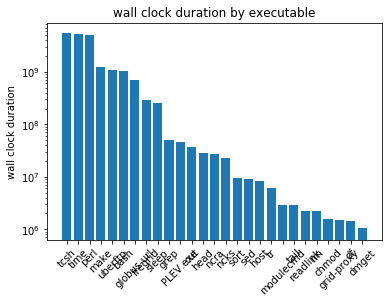

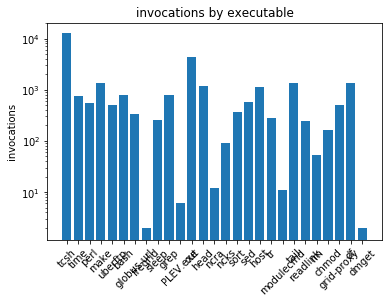

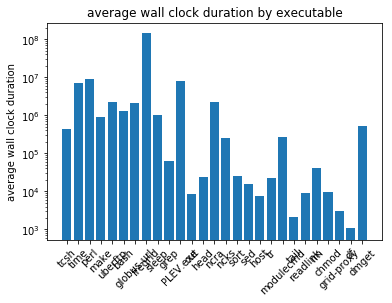

In [5]:
j = js[0].jobid
total, proc_dict = get_job_processes_reduce_attr(jobid=j, attr_name='duration', cutoff=1000000.0)
labels = []
y_val = []
y_val2 = []
y_val3 = []
labels = sorted(proc_dict.keys())
labels = sorted(proc_dict, key=lambda k: (proc_dict[k]["duration"]), reverse=True)
for k in labels:
    value = proc_dict[k]
    y_val3.append(value["duration"]/value["count"])
    y_val.append(value["duration"])
    y_val2.append(value["count"])
    
barplot(labels=labels,y_val=y_val,mn="wall clock duration")
barplot(labels=labels,y_val=y_val2,mn="invocations")
barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")



In [6]:
# Return list of objects for jobid

def get_processes_job_filter(jobid, pat=None):
    query = select ((p.exename, p.start, p.duration) for p in Process 
                    if p.job in select(j for j in Job if j.jobid == jobid)).order_by(2)
    if pat:
        query = query.filter(lambda p, q, r: p.startswith(pat))
    return query[:]

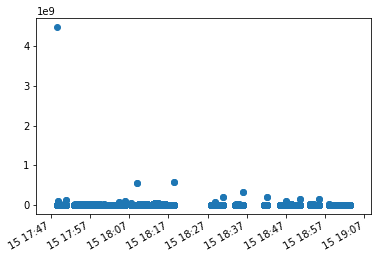

In [7]:
a = get_processes_job_filter(jobid=j)    
b = zip(*a)
plt.plot([],[])
plt.scatter(b[1],b[2])
plt.gcf().autofmt_xdate()

plt.show() 
#    value["duration"]
    #y_val.append()
#    print value["start"]
    #x_val.append(value["start"])

#x_val = [i for i in range(len(y_val))]
#print x_val, len(y_val)
##barplot(labels=labels,y_val=y_val3,mn="average wall clock duration")
#barplot(labels=labels,y_val=y_val,mn="wall clock duration")
#barplot(labels=labels,y_val=y_val2,mn="invocations")

In [278]:


# Lets examine tcsh

q = Process.select(lambda p: p.job==js[0] and p.exename=="tcsh").without_distinct()
q = select(p.threads.metrics for p in q).without_distinct()
q = select((m.value,m.metricname.name,m.thread) for m in q).without_distinct().order_by(3)
# order by is important as it always produces the same order of threads
meas = {}
for m in q[:]:
    if m[1] not in meas:
        meas[m[1]] = [ (m[0], m[2]) ]
    else:
        meas[m[1]].append( (m[0], m[2]) )


PERF_COUNT_SW_CPU_CLOCK [(114692.0, Thread[3]), (246946.0, Thread[5])]
cancelled_write_bytes [(0.0, Thread[3]), (0.0, Thread[5])]
delayacct_blkio_time [(0.0, Thread[3]), (0.0, Thread[5])]
guest_time [(0.0, Thread[3]), (0.0, Thread[5])]
inblock [(0.0, Thread[3]), (0.0, Thread[5])]
invol_ctxsw [(2.0, Thread[3]), (1.0, Thread[5])]
majflt [(0.0, Thread[3]), (0.0, Thread[5])]
minflt [(389.0, Thread[3]), (390.0, Thread[5])]
num_threads [(1.0, Thread[3]), (1.0, Thread[5])]
outblock [(0.0, Thread[3]), (0.0, Thread[5])]
processor [(3.0, Thread[3]), (3.0, Thread[5])]
rchar [(17394.0, Thread[3]), (17392.0, Thread[5])]
rdtsc_duration [(394174.0, Thread[3]), (849170.0, Thread[5])]
read_bytes [(0.0, Thread[3]), (0.0, Thread[5])]
rssmax [(2908.0, Thread[3]), (2900.0, Thread[5])]
starttime [(1826347780000.0, Thread[3]), (1825785530000.0, Thread[5])]
syscr [(39.0, Thread[3]), (39.0, Thread[5])]
syscw [(0.0, Thread[3]), (0.0, Thread[5])]
systemtime [(0.0, Thread[3]), (0.0, Thread[5])]
time_oncpu [(36727

In [284]:
def compute_quantiles(frame):
    retval = frame.quantile([.5,.999])
    return retval

def fetch_outliers(pdf, metric):
    frame_quantiles = compute_quantiles(pdf[metric])
    return pdf[pdf[metric] > frame_quantiles[.999]]

def print_outliers(d, metric):
    for index, row in d.iterrows():
        thr = row['thread']
        proc = thr.process
        print thr,proc,proc.exename,"at",proc.start,metric,row[metric]

def get_outliers(dfi, metric):
#    df.boxplot(column=metric)
#    plt.show()
#    print df[metric].describe()
    dfol = fetch_outliers(dfi, metric)
    return dfol 
#    print df[metric].describe()
#    df.boxplot()
#    plt.show()
#    return dfi,dfol


# Very important to be sorted by thread object here!

tofind = [ "delayacct_blkio_time","usertime","invol_ctxsw","time_oncpu","systemtime" ]
df = pd.DataFrame()
for k in tofind:
    if k in meas:
        v,t = zip(*meas[k])
        df[k] = v
        if 'thread' not in df.columns:
            df['thread'] = t

t = Thread[41211]
print t,t.process
print t.metrics.value
# Thread[23153] Process[20602] tcsh at 2019-02-15 18:46:10.422353 delayacct_blkio_time 10000.0
# Thread[38021] Process[33690] tcsh at 2019-02-15 18:01:31.958077 delayacct_blkio_time 2520000.0
        

for metric in tofind:
    print
#    a = pd.DataFrame()
    b = pd.DataFrame()
    b = get_outliers(df[['thread',metric]].copy(),metric)
    print_outliers(b,metric)
    print len(b.index),"outliers found for",metric
    print "mean before:",df[metric].describe()["mean"]
#    print "mean after:",b[metric].describe()["mean"]


Thread[41211] Process[36496]
Multiset({0.0: 2, 1.0: 1, 8.0: 1, 220.0: 1, 1949.0: 1, 3441.0: 1, 4096.0: 1, 4528.0: 1, 7960.0: 1, 8048.0: 1, 8181.0: 1, 27552.0: 1, 88964.0: 1, 151508.0: 1, 383132.0: 1, 872867.0: 1, 894863.0: 1, 2520000.0: 1, 4120576.0: 1, 14106624.0: 1, 17221703.0: 1, 1570974729.0: 1, 1768347538.0: 1, 1824921900000.0: 1, 15514802151550.0: 1})

Thread[36035] Process[31944] tcsh at 2019-02-15 17:48:42.731348 delayacct_blkio_time 10000.0
Thread[41211] Process[36496] tcsh at 2019-02-15 17:48:39.246671 delayacct_blkio_time 2520000.0
2 outliers found for delayacct_blkio_time
mean before: 193.4250764525994

Thread[265] Process[241] tcsh at 2019-02-15 17:56:06.790720 usertime 18997.0
Thread[537] Process[486] tcsh at 2019-02-15 18:03:31.668908 usertime 18997.0
Thread[14304] Process[12732] tcsh at 2019-02-15 18:12:34.015025 usertime 19996.0
Thread[16488] Process[14706] tcsh at 2019-02-15 18:01:52.127343 usertime 18997.0
Thread[20680] Process[18423] tcsh at 2019-02-15 18:54:46.9090

In [273]:

t = Thread[27377]
print t,t.process,t.metrics.value


Thread[27377] Process[24267] Multiset({0.0: 11, 1.0: 2, 2.0: 1, 3.0: 1, 39.0: 1, 390.0: 1, 999.0: 1, 2904.0: 1, 2999.0: 1, 17394.0: 1, 31500.0: 1, 242351.0: 1, 832970.0: 1, 4432518.0: 1, 1826634490000.0: 1})


In [ ]:
import pandas as pd
df = pd.DataFrame({'Duration': q[:]})
print df.describe()
array = [durs]
plt.boxplot(array,showmeans=True,whis=99)
plt.show()



In [ ]:
#    for key, value in proc_dict.iteritems():
#        if value["threads"] > value["count"]:
#            print key, value["duration"], total, value["duration"]*100.0/total 
#        names["foo"] += 1
#        attr[p.exename] += p.duration



#jobs=select(j for j in Job if j.jobid == jobid)
#for j in jobs:
#    print "Job found:",j.jobname, j.jobid

# print "TOTAL:",len(processes)
#print processes
#for p in processes:
#    print p
#processes=select((p.exename, p.duration) for p in Process if p.job == j and p.exename == "tcsh").order_by(-2)
#print "TCSH:", len(processes)
#print "SUM:",sum(p.duration for p in Process if p.job == j and p.exename == "tcsh")
# for p in processes:
#    print p[1]
# Slice up tuples into X and Y
# print labels



In [ ]:
#    
    Process.select(lambda p: p.job == jobid)
    
    j.processes w# lookup job


    doit = False
        for pat in exepatlist:
            if fnmatch.fnmatch(p.exename, pat):
                doit = True
                break
        if not doit:
            continue
total, proc_dict = get_job_processes_full_attr(jobid='19917749.moab01.princeton.rdhpcs.noaa.gov', attr_name='duration', exepatlist=["gl*"])

#print proc_dict
x_val = []
y_val = []
for key, value in proc_dict.iteritems():
    plt.plot([ i for i in range(len(value["start"]))],value["start"])
    plt.show()

print value["start"]

#threads=select(p.threads for p in Process if p.job == j)
#print "TOTAL:",len(threads)
#print j
metricnames=select(m.name for m in MetricName)[:]
#print metricnames, len(metricnames)

values=select((m.thread.process.exename, m.metricname.name, sum(m.value)) for m in Metric if m.thread.process.job == j and m.thread.process.exename == 'which').order_by(2)
#metricname == MetricName["usertime"])[:10]
#print len(values), values[:]
# foundmetricnames=[t[1] for t in values][:len(metricnames)]
# print foundmetricnames,len(foundmetricnames)
numexes = len(values)/len(metricnames)

# Iterate over metrics, using number of executables at a time
for offset in range(0,len(values),numexes):
    mn = (values[:])[offset][1]
    procnames = [p[0] for p in values[offset:offset+numexes]]
    y_val = [p[2] for p in values[offset:offset+numexes]]
    if all(i == 0.0 for i in y_val):
        print offset,mn,"had no non-zero values"
    else:
        print offset, mn
        print procnames
        print y_val
        #barplot(labels=procnames,y_val=y_val,mn=mn)

values=select((m.thread.process.pid, m.value) for m in Metric if m.metricname.name == "rssmax" and m.thread.process.exename == 'which').order_by(2)





In [ ]:
values=select((m.thread.process.exename, sum(m.thread.process.duration), m.metricname.name, sum(m.value)) for m in Metric if m.metricname.name == "systemtime" or m.metricname.name == "usertime" ).order_by(3)
print len(values)
i=len(values)/2
print i,values[0:1]
print values[64:65]
procnames = [p[0] for p in values[0:i]]
y_val1 = [p[3] for p in values[0:i]]
y_val2 = [p[3] for p in values[i:len(values)]]
barplot_stack(labels=procnames,y_val=y_val1, y2_val=y_val2,mn=["systemtime", "usertime"],yscale="linear",ylim=(0,100000000))

#

In [ ]:
print len(values[:])

In [ ]:
for p in processes:
    print count(p.threads), p.exename, p.duration
    #s um(p.threads.duration), p.threads.metrics
    threads=select (t for t in Thread if t.process == p)
    for t in threads:
            print "\t", t.tid, t.duration

In [ ]:
select((p.exename, count(p)) for p in Process if p.job == j).without_distinct()[:]
                                                                                 